## Install the library and toolboxs

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import numpy as np
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

!pip install ipython-autotime

%load_ext autotime
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
# Check GPU
!nvidia-smi

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Wed Apr 22 20:12:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Pr

## Load preprocessed data from drive and split to training and validation

In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
# Load the dataset
level = 3
variable_folder =  "/content/drive/My Drive/Dataset"
file_name = "dataset_preprocessed" + "_level" + str(level) + "_balanced.pkl"
with open(os.path.join(variable_folder, file_name), 'rb') as f:
    dataset_patches, dataset_label = pickle.load(f)

time: 6.47 s


In [0]:
# Split train and validation set
X_train, X_val, y_train, y_val = train_test_split(
...     dataset_patches, dataset_label, test_size=0.2, random_state=42)
X_train = np.array(X_train).astype('float32') / 255.
X_val = np.array(X_val).astype('float32') / 255.

# Check the split
print("Size of the train set: {:d}".format(len(y_train)))
print("Size of the validation set: {:d}".format(len(y_val)))
print("Size of the train data sample: " + str(X_train[0].shape))
print("Size of the validation data sample: " + str(X_val[0].shape))


Size of the train set: 48966
Size of the validation set: 12242
Size of the train data sample: (32, 32, 3)
Size of the validation data sample: (32, 32, 3)
time: 401 ms


## Simple custom CNN

In [0]:
#### Data augmentation
from keras.preprocessing.image import ImageDataGenerator

# Create the augmentation generator
train_datagen = ImageDataGenerator(
    shear_range=0.2,    
    width_shift_range=0.2,
    height_shift_range=0.2,  
    horizontal_flip=True,
    vertical_flip=True)

# train_datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     brightness_range=(0.8, 1.2),
#     channel_shift_range=0.2,
#     horizontal_flip=True,)

train_datagen.fit(X_train)

# Note that the validation data should not be augmented!
train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=128)

Using TensorFlow backend.


time: 342 ms


### Construct a simple custom CNN with subclassing (4 convolutional blocks)

In [0]:
# F-1 metric (if you want to use)
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [0]:
# Make a custom block of convoluation, batch norm and drop out
class ConvAndMaxPoolBlock(keras.layers.Layer):
 def __init__(self, input_shape=[], n_channel=32, kernel_size = (2, 2), activation='relu',
              l2_weight=0.01, pool_size=(2,2), stride=(1, 1), dropout_rate=0.2, **kwargs):
   super().__init__(**kwargs)
   self.n_channel = n_channel
   self.conv_layer = keras.layers.Conv2D(filters=n_channel, input_shape=input_shape, kernel_size=kernel_size, strides=stride, kernel_regularizer=keras.regularizers.l2(l2_weight), padding='same')
   self.batch_norm_layer = keras.layers.BatchNormalization()
   self.dropout_layer = keras.layers.Dropout(rate=dropout_rate)
   self.activation_layer = keras.layers.Activation(activation)
   self.maxpool_layer = keras.layers.MaxPool2D(pool_size=pool_size)

 def call(self, inputs):
   Z = inputs
   Z = self.conv_layer(Z)
   Z = self.batch_norm_layer(Z)
   Z = self.activation_layer(Z)
   Z = self.dropout_layer(Z)
   Z = self.maxpool_layer(Z)
   return Z

 def get_config(self):                                               
   base_config = super().get_config()                              
   return {**base_config,                                          
            "n_channels": self.n_channel}

# Make a custom model
class MyCustomModel(keras.Model):
  def __init__(self, input_shape, output_dim, l2_weight, dropout_rate, **kwargs):
    super().__init__(**kwargs)
    self.output_dim = output_dim
    self.block1 = ConvAndMaxPoolBlock(n_channel=32, input_shape = input_shape, kernel_size = (3, 3), activation='relu', l2_weight=l2_weight, dropout_rate=dropout_rate, pool_size=(2,2))
    self.block2 = ConvAndMaxPoolBlock(n_channel=64, kernel_size = (5, 5), activation='relu', l2_weight=l2_weight, dropout_rate=dropout_rate, pool_size=(2,2))
    self.block3 = ConvAndMaxPoolBlock(n_channel=128, kernel_size = (7, 7), activation='relu', l2_weight=l2_weight, dropout_rate=dropout_rate, pool_size=(2,2))
    self.block4 = ConvAndMaxPoolBlock(n_channel=256, kernel_size = (9, 9), activation='relu', l2_weight=l2_weight, dropout_rate=dropout_rate, pool_size=(2,2))    
    self.globpool_layer = keras.layers.GlobalAveragePooling2D()
    self.out_layer = keras.layers.Dense(output_dim, activation='sigmoid')

  def call(self, inputs):
    Z = inputs
    Z = self.block1(Z)
    Z = self.block2(Z)
    Z = self.block3(Z)
    Z = self.block4(Z)
    Z = self.globpool_layer(Z)
    return self.out_layer(Z)

  def get_config(self):                                           
    base_config = super().get_config()                           
    return {**base_config,                                       
            "output_dim": self.output_dim}    

# Create the model
l2_weight = 0.0
dropout_rate = 0.0
model = MyCustomModel(input_shape=X_train[0].shape, output_dim=1, l2_weight=l2_weight, dropout_rate=dropout_rate)

# Compile the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, monitor='val_loss')
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

time: 8.31 s


### Train the model on a single batch. We should see the loss goes to 0 and accuracy to 100%.

Text(0, 0.5, 'Loss')

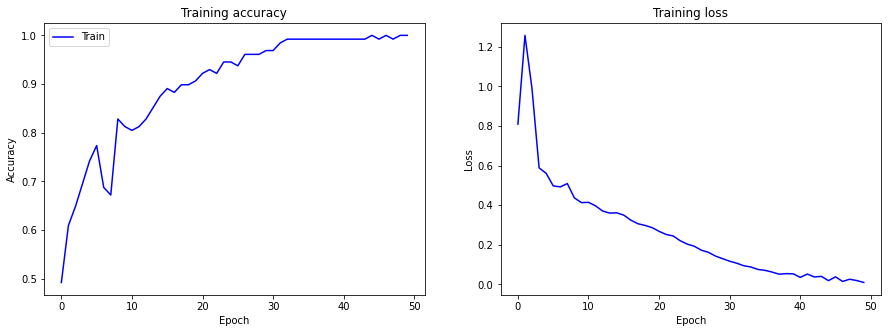

time: 2.6 s


In [0]:
# Try training on a single batch first
train_steps = 50
loss = []
accuracy = []
for i in range(train_steps):
  metrics = model.train_on_batch(X_train[:128, :, :, :], y_train[:128])
  loss.append(metrics[0])
  accuracy.append(metrics[1])


epochs = range(len(accuracy))
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
plt.title('Training accuracy')
plt.plot(epochs, accuracy, color='blue', label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

ax1 = fig.add_subplot(122)
plt.title('Training loss')
plt.plot(epochs, loss, color='blue', label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Start the training

#### Train without data augmentation

In [0]:
# Train without augmentation
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=200, callbacks=[early_stopping_cb], batch_size=128)

#### Train with data augmentation

In [0]:
# Train the model with augmentation
history = model.fit(
      train_generator,
      steps_per_epoch=X_train.shape[0] / 128,
      epochs=200,
      validation_data=(X_val, y_val), 
      callbacks=[early_stopping_cb])      

In [0]:
# Save the model
model.save('/content/drive/My Drive/Train_model/custom_model_relu_rescaleX_dataAugFlipShift0.2Shear', save_format="tf")


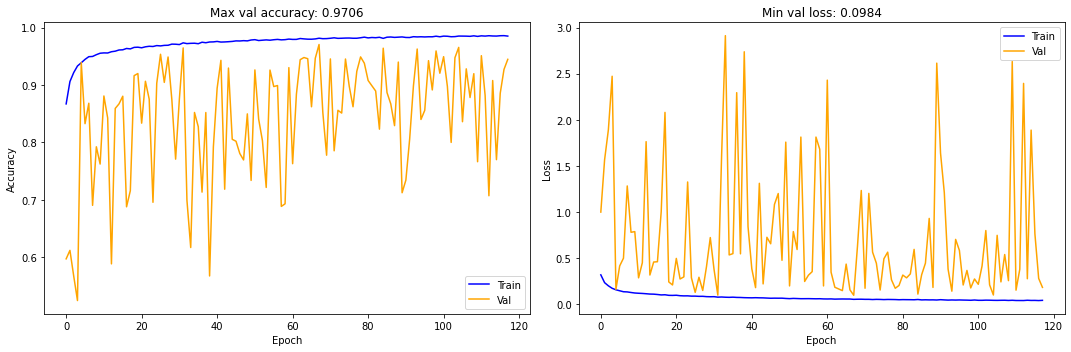

time: 2.17 s


In [0]:
# Plot the history of training using accuracy metrics
fig_save_path = "/content/drive/My Drive/Train_figs/custom_model_relu_rescaleX_dataAugFlipShift0.2Shear"
def plot_training(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot the result
  epochs = range(len(acc))
  fig = plt.figure(figsize=(15, 5))
  ax1 = fig.add_subplot(121)
  plt.title('Max val accuracy: {0:.4f}'.format(max(val_acc)))
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  ax1 = fig.add_subplot(122)
  plt.title('Min val loss: {0:.4f}'.format(min(val_loss)))
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Save the figure
  path = fig_save_path + ".png"
  plt.tight_layout()
  plt.savefig(path, format="png", dpi=300)

plot_training(history)

### Try the model on validation and train set

In [0]:
# Check the model on train data
label_predict = model.predict(X_train)
label_predict = np.round(np.squeeze(label_predict))
train_acc = sum(label_predict == y_train) / len(y_train)
print("Train accuracy: {:.1f}%".format(train_acc*100))

Train accuracy: 97.1%
time: 3.27 s


In [0]:
# Check the model on val data
label_predict = model.predict(X_val)
label_predict = np.round(np.squeeze(label_predict))
train_acc = sum(label_predict == y_val) / len(y_val)
print("Val accuracy: {:.1f}%".format(train_acc*100))

Val accuracy: 97.1%
time: 879 ms


### Plot using f-1 metric

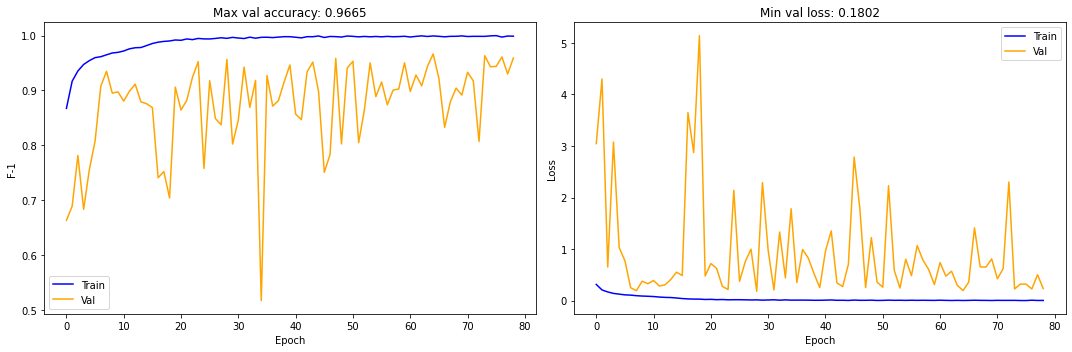

time: 1.48 s


In [0]:
# Plot the history of training using f1 metrics
fig_save_path = "/content/drive/My Drive/Train_figs/custom_model_relu_rescaleX_f1"
def plot_training(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['f1']
  val_acc = history.history['val_f1']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot the result
  epochs = range(len(acc))
  fig = plt.figure(figsize=(15, 5))
  ax1 = fig.add_subplot(121)
  plt.title('Max val accuracy: {0:.4f}'.format(max(val_acc)))
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('F-1')
  plt.legend()

  ax1 = fig.add_subplot(122)
  plt.title('Min val loss: {0:.4f}'.format(min(val_loss)))
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Save the figure
  path = fig_save_path + ".png"
  plt.tight_layout()
  plt.savefig(path, format="png", dpi=300)

plot_training(history)